In [ ]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

A general "sequential" neural network can be expressed as

$$f(x) = \underset{i=1}{\overset{n}{\Huge{\kappa}}} R_i(A_ix+b_i)$$

where $$\underset{i=1}{\overset{n}{\Huge{\kappa}}}f_i(x) = f_n \circ f_{n-1} ... \circ f_1(x)$$ and the $A_i$ are matrices and the $b_i$ are bias vectors. Typically the $R_i$ are the same for all the layers (typically ReLU) **except** for the last layer, where $R_i$ is just is just the identity function

* **Note**: In clever architectures, like convolutional neural networks, the $A_i$'s become sparse matrices (most of there parameters are fixed to equal zero).

Download from www.di.ens.fr/~lelarge/MNIST.tar.gz

In [ ]:
x,y= torch.load('/content/training.pt')

In [ ]:
y = y[:10]
y = y.reshape((-1,1))
y

tensor([[5],
        [0],
        [4],
        [1],
        [9],
        [2],
        [1],
        [3],
        [1],
        [4]])

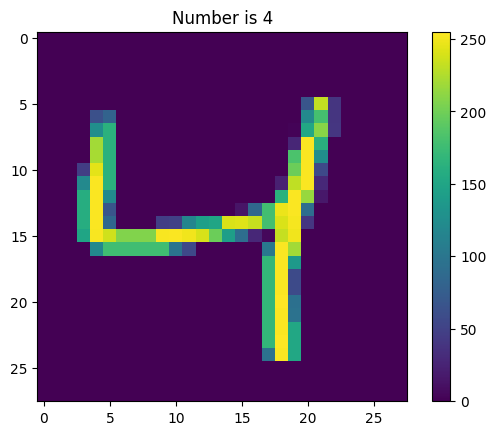

In [ ]:
plt.imshow(x[2].numpy())
plt.title(f'Number is {y[2].numpy()}')
plt.colorbar()
plt.show()

# The One Hot Encoder

In [ ]:
y_original = torch.tensor([2, 4, 3, 0, 1]).view((-1,1))
y_new = F.one_hot(y_original)

In [ ]:
y_original

tensor([[2],
        [4],
        [3],
        [0],
        [1]])

In [ ]:
y_new

tensor([[[0, 0, 1, 0, 0]],

        [[0, 0, 0, 0, 1]],

        [[0, 0, 0, 1, 0]],

        [[1, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0]]])

Now lets do it on the dataset

In [ ]:
y

tensor([5, 0, 4,  ..., 5, 6, 8])

In [ ]:
y_new

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]])

In [ ]:
y_new = F.one_hot(y, num_classes=10)
y_new.shape

torch.Size([60000, 10])

# Issues with the Images

In [ ]:
x.shape

torch.Size([60000, 28, 28])

The images are currently 28x28, but we want to turn the images (the `xs`) into a vector (which will be length $28^2 = 784$). We can do this using the `.view` property of a tensor.

In [ ]:
x.view(-1,28**2).shape

torch.Size([60000, 784])

# PyTorch Dataset Object

In [ ]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        self.x = self.x / 255.
        self.y = F.one_hot(self.y,num_classes=10)
        self.y = self.y.to(torch.float32)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [ ]:
y.shape

torch.Size([10000])

In [ ]:
train_ds = CTDataset('/content/training.pt')


Datasets of a `__len__` and `__getitem__` method, so they can be used with python functionality

In [ ]:
len(train_ds)

60000

We can also use slicing:

In [ ]:
xs, ys = train_ds[0:4]

In [ ]:
ys.shape

torch.Size([4, 1])

# PyTorch DataLoader Object

We can then put the `Dataset` objects inside a `DataLoader` class. This is useful because we can specify a `batch_size`. Each iteration through the dataloader will yield a tensor where the first dimension is equal to the `batch_size`.

In [ ]:
train_dl = DataLoader(train_ds, batch_size=5)
print(len(train_dl))

12000


In [ ]:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([5, 28, 28])
torch.Size([5, 1])


Since the `batch_size` here is 5, and there are 60000 images, the length of the `DataLoader` object should be 12000.

In [ ]:
len(train_dl)
x,y = train_ds[:10]
print(x[0].shape)
print(y[0])

torch.Size([28, 28])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


# Cross Entropy Loss

Watch: https://www.youtube.com/watch?v=wq1K8F-S0AI

In [ ]:
L = nn.MSELoss()

# The Network

In [ ]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2,100)
        self.Matrix2 = nn.Linear(100,50)
        self.Matrix3 = nn.Linear(50,10)
        self.R = nn.ReLU()
    def forward(self,x):
        x = x.view(-1,28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

In [ ]:
f = MyNeuralNet()


Look at network predictions (before optimization):

In [ ]:
xs.shape

torch.Size([4, 28, 28])

In [ ]:
f(xs)

tensor([[-0.0304, -0.0604,  0.1249, -0.0723,  0.1393,  0.0109, -0.1687,  0.1280,
          0.0197, -0.1081],
        [-0.0233, -0.0476,  0.1448, -0.0931,  0.1315, -0.0055, -0.1567,  0.1164,
          0.0444, -0.1039],
        [-0.0448, -0.0625,  0.0839, -0.0680,  0.0799, -0.0115, -0.1249,  0.1175,
          0.0194, -0.1151],
        [-0.0843, -0.0833,  0.1176, -0.0772,  0.0681,  0.0048, -0.1693,  0.1070,
          0.0148, -0.1294]], grad_fn=<AddmmBackward0>)

This is what they should eventually be equal to:

In [ ]:
ys

tensor([[5.],
        [0.],
        [4.],
        [1.]])

We can compute the loss between such predictions.

In [ ]:
L(f(xs), ys)

tensor(-0., grad_fn=<DivBackward1>)

We want these predictions `f(xs)` to match the `ys` for all images. For these to match, the loss function `L(f(xs), ys)` should be as small as possible. As such, we adjust the weights of `f` such that `L` becomes as small as possible. This is done below:

# Training

This training loop is copied from the previous tutorial, with a few modifications

In [ ]:
def train_model(dl, f, n_epochs=20):
    # Optimization
    opt = SGD(f.parameters(), lr=0.01)
    L = nn.CrossEntropyLoss()

    # Train model
    losses = []
    epochs = []
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}')
        N = len(dl)
        for i, (x, y) in enumerate(dl):
            # Update the weights of the network
            opt.zero_grad()
            loss_value = L(f(x), y)
            loss_value.backward()
            opt.step()
            # Store training data
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

Lets call this function to train the model:

In [ ]:
epoch_data, loss_data = train_model(train_dl, f,20)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [ ]:
tx,ty = torch.load('/content/test.pt')
print(tx.shape)
print(ty.shape)


torch.Size([10000, 28, 28])
torch.Size([10000])


In [ ]:

wr =0
y = y.to(torch.float32)
x = x.to(torch.float32)
for ind in range(60000):
  y_pred = int(round(f(x[ind]).item()))
  y_act = int(y[ind].item())
  if y_pred!=y_act:
    wr = wr + 1
wr

59506

Lets plot the loss function `L(f(xs),ys)` for each batch of `xs, ys` (`batch_size` is 5) throughout the training procedure

Text(0.5, 1.0, 'Cross Entropy (per batch)')

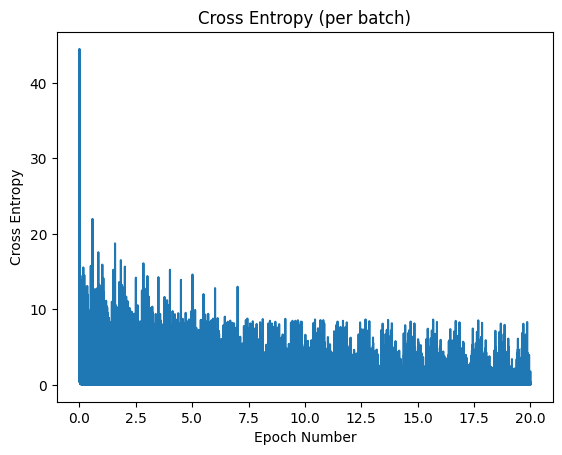

In [ ]:
plt.plot(epoch_data, loss_data)
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (per batch)')

Each one of these data points corresponds to the loss evaluated on a batch of 5 images. An entire epoch, however, is 60000 images. We can average the loss across all the data per epoch to get the loss for all 60000 images.

* Since there are 20 total epochs, we split the array above into 20 equal portions and take the mean of each portion

In [ ]:
epoch_data_avgd = epoch_data.reshape(20,-1).mean(axis=1)
loss_data_avgd = loss_data.reshape(20,-1).mean(axis=1)

Text(0.5, 1.0, 'Cross Entropy (avgd per epoch)')

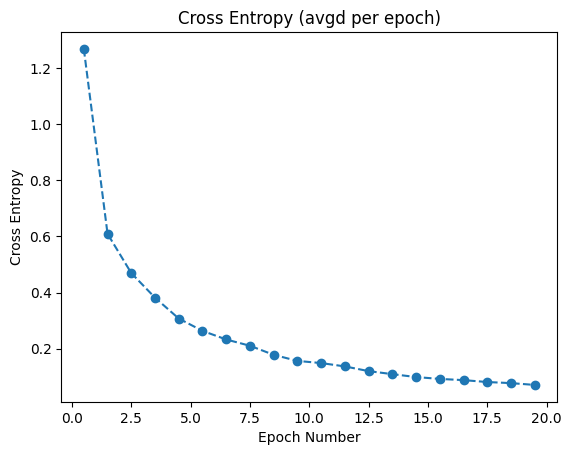

In [ ]:
plt.plot(epoch_data_avgd, loss_data_avgd, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')

Look at a sample image label $y$:

In [ ]:
y_sample = train_ds[0][1]
y_sample

tensor([5.])

Look at sample prediction $\hat{y}$

In [ ]:
x_sample = train_ds[0][0]
yhat_sample = f(x_sample)
yhat_sample

tensor([[4.5782]], grad_fn=<AddmmBackward0>)

To get what image this is, we should really be taking the index of the maximum value

In [ ]:
torch.argmax(yhat_sample)

tensor(5)

In [ ]:
plt.imshow(x_sample)

NameError: ignored

It matches up! Lets look at a few more

In [ ]:
x,y = torch.load('/content/training.pt')
x = x/255
y = y.to(torch.float32)
yhats = f(x).argmax(axis=1)

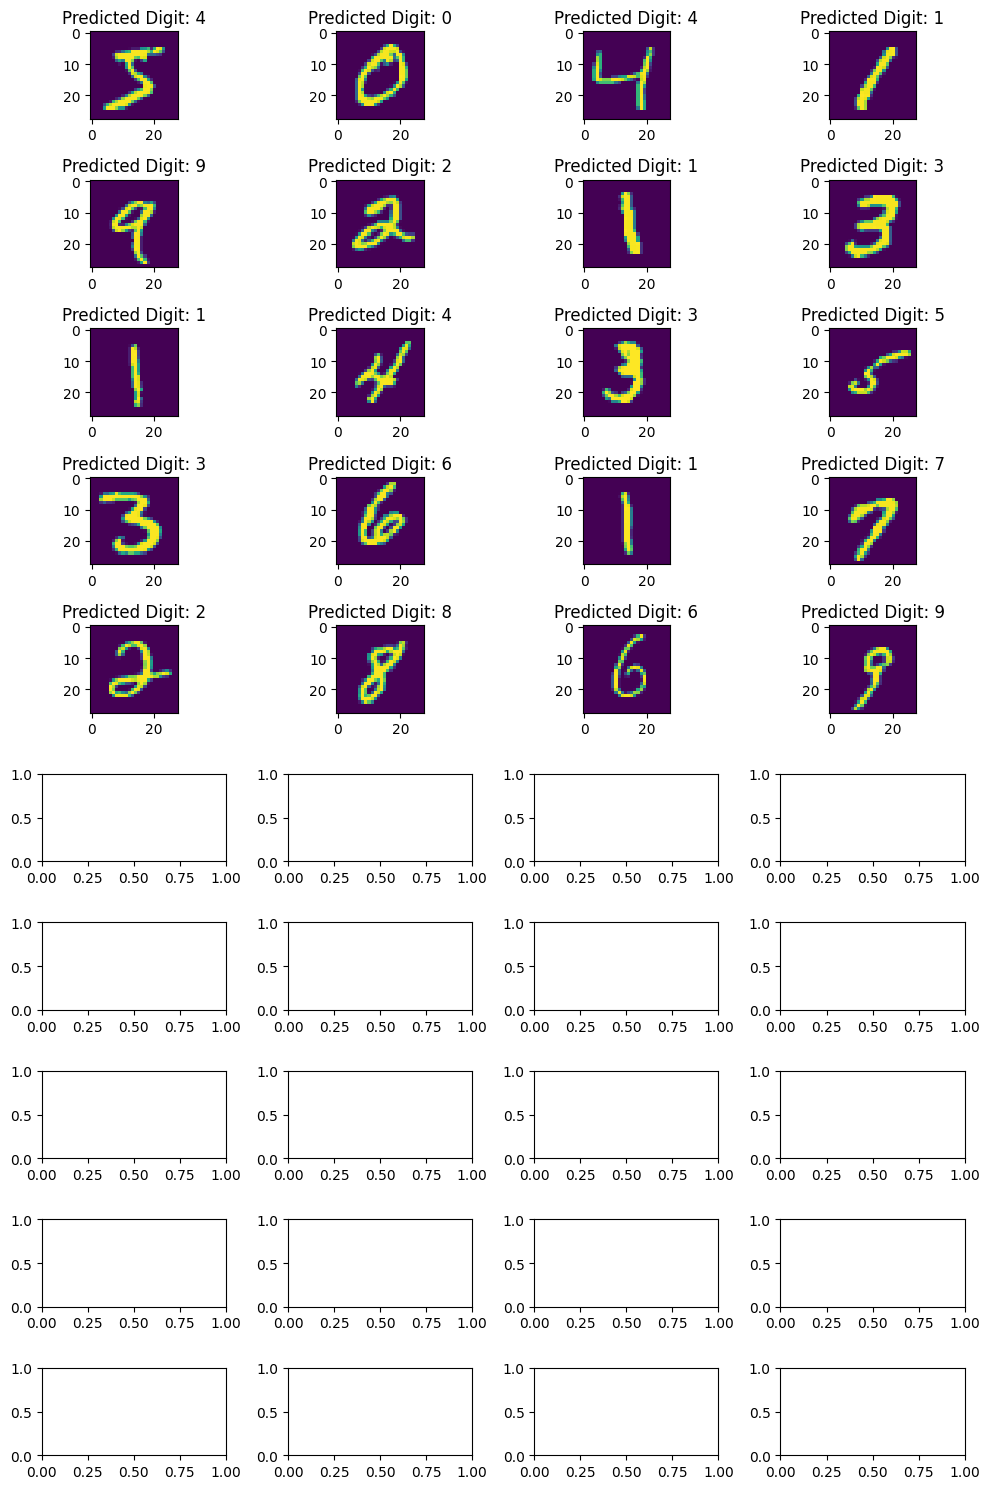

In [ ]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(20):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {round(yhats[i].item())}')
fig.tight_layout()
plt.show()

In [ ]:
wr = 0
print(y[0])
for inde in range(60000):
  y_act = y[inde]
  y_pred = yhats[inde]
  if y_act!=y_pred:
    wr = wr + 1
print(wr)
print(wr/60000)
print(100-(wr/60000)*100)


tensor(5.)
11
0.00018333333333333334
99.98166666666667


In [ ]:
perce =100- (wr/2000)*100
perce

71.5

These are evaluated on the training dataset, however. To test the generalizability of the model, we must evaluate the models predictive power on the test dataset (these are images the model did not see during training):

In [ ]:
xs, ys = test_ds[:2000]
yhats = f(xs).argmax(axis=1)

NameError: ignored

Plot 40 predictions:

NameError: ignored

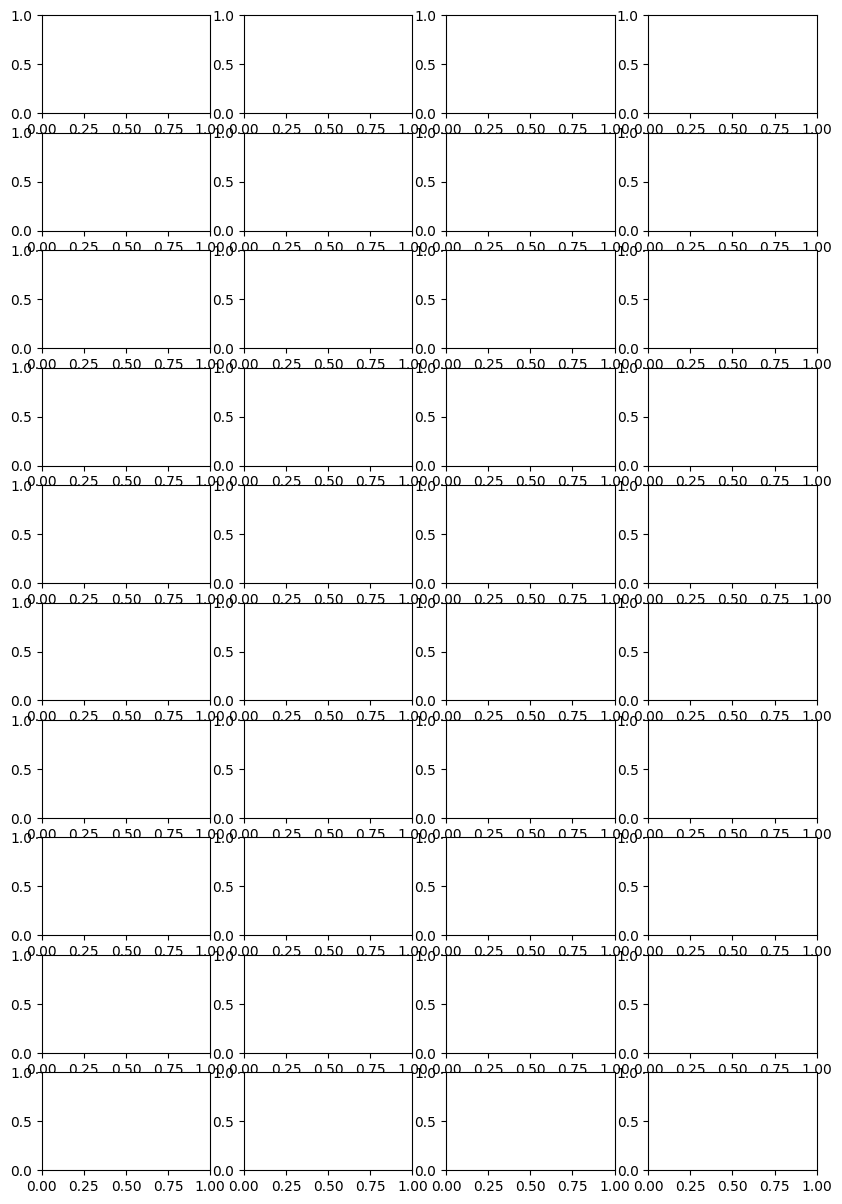

In [ ]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()